In [48]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as function
from torchvision import datasets
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler

In [49]:
# Set seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Initialize generator
generator = torch.Generator().manual_seed(seed)

# For Fashion MNIST
trainset_fashion = datasets.FashionMNIST('./data', download=True, train=True, transform=transforms.ToTensor())
trainloader_fashion = DataLoader(trainset_fashion, batch_size=64, shuffle=True, generator=generator)

testset_fashion = datasets.FashionMNIST('./data', download=True, train=False, transform=transforms.ToTensor())
testloader_fashion = DataLoader(testset_fashion, batch_size=64, shuffle=False)


# For CIFAR-10
transform_cifar = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset_cifar = datasets.CIFAR10('./data', download=True, train=True, transform=transform_cifar)
trainloader_cifar = DataLoader(trainset_cifar, batch_size=64, shuffle=True, generator=generator)

testset_cifar = datasets.CIFAR10('./data', download=True, train=False, transform=transform_cifar)
testloader_cifar = DataLoader(testset_cifar, batch_size=64, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [50]:
class DynamicCNN(nn.Module):
    def __init__(self, num_classes, input_channels, input_size):
        super(DynamicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()

        # Calculate the size of the fully connected layer
        self.fc_input_size = 64 * (input_size // 4) * (input_size // 4)

        self.fc1 = nn.Linear(self.fc_input_size, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

class CNN:
    def __init__(self, num_classes, input_channels, input_size):
        self.num_classes = num_classes
        self.input_channels = input_channels
        self.input_size = input_size

    @staticmethod
    def validate(model, data, device):
        correct = 0
        with torch.no_grad():
            for images, labels in data:
                images = images.to(device)
                labels = labels.to(device)
                x = model(images)
                value, pred = torch.max(x, 1)
                correct += (pred == labels).sum().item()
        accuracy = 100 * correct / len(data.dataset)
        return accuracy

    def train(self, trainloader, testloader, num_epochs=5, lr=0.001, device="cpu"):
        accuracies = []
        cnn = DynamicCNN(self.num_classes, self.input_channels, self.input_size).to(device)
        cec = nn.CrossEntropyLoss()
        optimizer = optim.Adam(cnn.parameters(), lr=lr)
        max_accuracy = 0
        best_model = None

        for epoch in range(num_epochs):
            cnn.train()
            for images, labels in trainloader:
                images = images.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                pred = cnn(images)
                loss = cec(pred, labels)
                loss.backward()
                optimizer.step()

            cnn.eval()
            accuracy = self.validate(cnn, testloader, device)
            accuracies.append(accuracy)

            if accuracy > max_accuracy:
                best_model = copy.deepcopy(cnn)
                max_accuracy = accuracy

            print("Epoch", epoch + 1, ": Accuracy", accuracy, "%")

        return accuracies, best_model


In [51]:
cnn_cifar = CNN(10, 3, 32)
accuracies_cifar, best_model_cifar = cnn_cifar.train(trainloader_cifar, testloader_cifar, num_epochs=5, lr=0.001, device="cpu")

Epoch 1 : Accuracy 61.45 %
Epoch 2 : Accuracy 66.85 %
Epoch 3 : Accuracy 69.01 %
Epoch 4 : Accuracy 71.08 %
Epoch 5 : Accuracy 71.61 %


In [52]:
cnn_fashion = CNN(10, 1, 28)
accuracies_fashion, best_model_fashion = cnn_fashion.train(trainloader_fashion, testloader_fashion, num_epochs=5, lr=0.001, device="cpu")

Epoch 1 : Accuracy 87.26 %
Epoch 2 : Accuracy 87.83 %
Epoch 3 : Accuracy 90.04 %
Epoch 4 : Accuracy 90.07 %
Epoch 5 : Accuracy 91.08 %


Text(0.5, 1.0, 'CNN models')

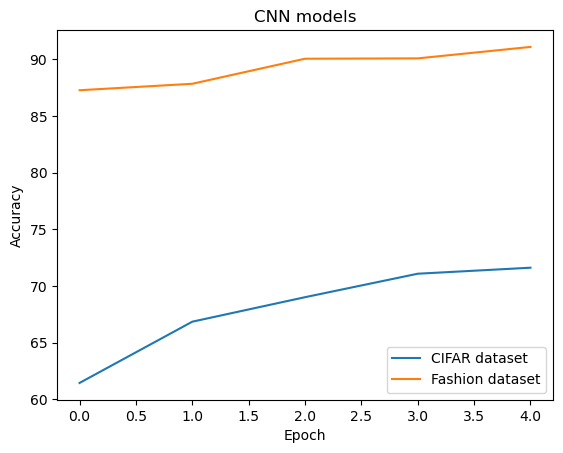

In [53]:
plt.plot(accuracies_cifar, label="CIFAR dataset")
plt.plot(accuracies_fashion, label="Fashion dataset")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN models")